This cell installs required packages and imports all necessary libraries.
It sets up the environment for audio processing, machine learning, and visualization.

In [72]:
!pip install -q librosa tensorflow soundfile pydub seaborn
!apt-get -qq install -y ffmpeg

import os
import numpy as np
import pickle
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Audio
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Librosa version: {librosa.__version__}")

All libraries imported successfully!
TensorFlow version: 2.19.0
Librosa version: 0.11.0


Mounting Google Drive and setting global configurations. Also, defining constants for audio processing (e.g., sample rate, duration) and known speakers.

In [73]:
from google.colab import drive
drive.mount('/content/drive')

# Set base path to audio folders
AUDIO_PATH = '/content/drive/MyDrive/Formative 2 - Images and Audios/voice_auth'
print("Audio folder contents:", os.listdir(AUDIO_PATH))

# Global configs
TARGET_SR = 16000  # Sample rate for resampling
DURATION = 3.0  # Max audio duration in seconds
N_MFCC = 13  # Number of MFCC features
MAX_SAMPLES = int(TARGET_SR * DURATION)

# Known speakers (folder names)
KNOWN_SPEAKERS = ['james', 'mathias', 'souvede', 'pretty']

# Phrase mapping based on keywords in filename
PHRASE_KEYWORDS = {
    'approve': 'yes approve',
    'confirm': 'confirm transaction'
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Audio folder contents: ['mathias', 'pretty', 'souvede', 'james', 'voice_auth_model.h5', 'speaker_encoder.pkl', 'phrase_encoder.pkl', 'unknown', 'voice_auth_model_5class.h5', 'speaker_encoder_5.pkl']


This cell loads audio files from known speakers, extracts MFCC features, and assigns labels.
It parses filenames for speaker and phrase, skips invalid files, and stores data in arrays.

In [74]:
mfcc_list = []
speaker_labels = []
phrase_labels = []
file_paths = []

print("Loading known audio and extracting MFCCs...")

for speaker in KNOWN_SPEAKERS:
    speaker_path = os.path.join(AUDIO_PATH, speaker)
    if not os.path.exists(speaker_path):
        print(f"Warning: Folder not found: {speaker_path}")
        continue

    files = os.listdir(speaker_path)
    print(f"Found folder: {speaker} → {len(files)} files")

    for file in files:
        if not file.lower().endswith(('.m4a', '.mp3', '.ogg')):
            continue

        file_path = os.path.join(speaker_path, file)
        base = os.path.splitext(file)[0].lower()
        parts = [p.strip() for p in base.replace('copy of ', '').split('_')]
        file_speaker = parts[0]

        if file_speaker.startswith('souved'):
            file_speaker = 'souvede'
        elif file_speaker not in KNOWN_SPEAKERS:
            print(f"Speaker mismatch: {file_speaker} → skipping {file}")
            continue

        phrase_key = None
        for word in parts:
            if word in PHRASE_KEYWORDS:
                phrase_key = PHRASE_KEYWORDS[word]
                break

        if not phrase_key:
            print(f"Skipping (no phrase keyword): {file}")
            continue

        try:
            y, sr = librosa.load(file_path, sr=TARGET_SR)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            continue

        if len(y) > MAX_SAMPLES:
            y = y[:MAX_SAMPLES]
        else:
            y = np.pad(y, (0, MAX_SAMPLES - len(y)), mode='constant')

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T

        mfcc_list.append(mfcc)
        speaker_labels.append(file_speaker)
        phrase_labels.append(phrase_key)
        file_paths.append(file_path)

        print(f"  Loaded: {file} → {file_speaker} | '{phrase_key}'")

# Convert to arrays
X_known = np.array(mfcc_list)
print(f"\nKnown feature shape: {X_known.shape}")
print(f"Total known samples: {len(X_known)}")

Loading known audio and extracting MFCCs...
Found folder: james → 17 files
  Loaded: James_approve_1.m4a → james | 'yes approve'
  Loaded: James_approve_2.m4a → james | 'yes approve'
  Loaded: James_approve_3.m4a → james | 'yes approve'
  Loaded: James_approve_4.m4a → james | 'yes approve'
  Loaded: James_approve_5.m4a → james | 'yes approve'
  Loaded: James_approve_6.m4a → james | 'yes approve'
  Loaded: James_approve_7.m4a → james | 'yes approve'
  Loaded: James_confirm_1.m4a → james | 'confirm transaction'
  Loaded: James_confirm_2.m4a → james | 'confirm transaction'
  Loaded: James_confirm_3.m4a → james | 'confirm transaction'
  Loaded: James_confirm_4.m4a → james | 'confirm transaction'
  Loaded: James_confirm_5.m4a → james | 'confirm transaction'
  Loaded: James_confirm_6.m4a → james | 'confirm transaction'
  Loaded: James_confirm_7.m4a → james | 'confirm transaction'
  Loaded: James_confirm_8.m4a → james | 'confirm transaction'
  Loaded: James_confirm_9.m4a → james | 'confirm tr

This cell loads audio files from the unknown folder and extracts MFCC features. All unknown files are labeled as 'unknown' for the speaker class.

In [75]:
unknown_folder = os.path.join(AUDIO_PATH, 'unknown')
unknown_files = [os.path.join(unknown_folder, f) for f in os.listdir(unknown_folder)
                 if f.lower().endswith(('.m4a', '.mp3', '.ogg'))]

print(f"Found {len(unknown_files)} unknown files:")
for f in unknown_files:
    print("  ", os.path.basename(f))

unknown_mfccs = []
for file in unknown_files:
    try:
        y, sr = librosa.load(file, sr=TARGET_SR)
    except Exception as e:
        print(f"Error loading {file}: {e}")
        continue

    if len(y) > MAX_SAMPLES:
        y = y[:MAX_SAMPLES]
    else:
        y = np.pad(y, (0, MAX_SAMPLES - len(y)), mode='constant')

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T
    unknown_mfccs.append(mfcc)

X_unknown = np.array(unknown_mfccs)
print(f"\nUnknown feature shape: {X_unknown.shape}")
print(f"Total unknown samples: {len(X_unknown)}")

Found 15 unknown files:
   stranger_confirm_3.m4a
   stranger_confirm_2.m4a
   stranger_approve_1.m4a
   stranger_approve_2.m4a
   stranger_confirm_1.m4a
   stranger_approve_3.m4a
   stranger_approve_1 (1).m4a
   stranger_confirm_4.m4a
   stranger_confirm_5.m4a
   sranger_confirm_6.m4a
   stranger_approve_6.m4a
   stranger_approve_4.m4a
   stranger_approve_5.m4a
   random.mp3
   find.mp3

Unknown feature shape: (15, 94, 13)
Total unknown samples: 15


This cell combines known and unknown data, assigns speaker labels (5 classes: 4 known + unknown), and encodes labels.
Phrase labels are extended for unknowns (randomly assigned since they are not for verification).

In [76]:
# Combine MFCCs
X_combined = np.vstack([X_known, X_unknown])

# Speaker labels: known (0-3), unknown (4)
y_speaker_combined = np.concatenate([
    speaker_encoder.fit_transform(speaker_labels),  # Encode known
    np.full(len(X_unknown), 4)  # Unknown as class 4
])

# Extend phrase labels for unknowns (random 0 or 1, as phrase is secondary for unknowns)
y_phrase_combined = np.concatenate([
    phrase_encoder.fit_transform(phrase_labels),  # Known phrases
    np.random.randint(0, 2, size=len(X_unknown))  # Random for unknowns
])

# Update speaker encoder to include 'unknown'
speaker_encoder_5 = LabelEncoder()
speaker_encoder_5.fit(['james', 'mathias', 'pretty', 'souvede', 'unknown'])

# Re-encode y_speaker_combined with new encoder
y_speaker_combined = speaker_encoder_5.transform(
    [speaker_encoder.classes_[label] if label < 4 else 'unknown' for label in y_speaker_combined]
)

print(f"Combined features: {X_combined.shape}")
print(f"Speaker classes: {speaker_encoder_5.classes_}")
print(f"Phrase classes: {phrase_encoder.classes_}")
print(f"Total samples: {len(X_combined)}")

Combined features: (52, 94, 13)
Speaker classes: ['james' 'mathias' 'pretty' 'souvede' 'unknown']
Phrase classes: ['confirm transaction' 'yes approve']
Total samples: 52


This cell applies SpecAugment (time and frequency masking) to the combined data.
It generates 2 augmented versions per sample for robustness.

In [77]:
def spec_augment(mfcc, time_mask_max=12, freq_mask_max=3):
    # Apply time and frequency masking to MFCCs for augmentation.
    mfcc = mfcc.copy()
    t, f = mfcc.shape
    t_mask = np.random.randint(1, min(time_mask_max, t))
    t0 = np.random.randint(0, t - t_mask)
    mfcc[t0:t0 + t_mask, :] = 0
    f_mask = np.random.randint(1, min(freq_mask_max, f))
    f0 = np.random.randint(0, f - f_mask)
    mfcc[:, f0:f0 + f_mask] = 0
    return mfcc

X_aug_list = []
y_speaker_aug_list = []
y_phrase_aug_list = []

# Add original samples
for i in range(len(X_combined)):
    X_aug_list.append(X_combined[i])
    y_speaker_aug_list.append(y_speaker_combined[i])
    y_phrase_aug_list.append(y_phrase_combined[i])

# Add 2 augmented versions
for _ in range(2):
    for i in range(len(X_combined)):
        X_aug_list.append(spec_augment(X_combined[i]))
        y_speaker_aug_list.append(y_speaker_combined[i])
        y_phrase_aug_list.append(y_phrase_combined[i])

# Convert to arrays
X_aug = np.stack(X_aug_list)
y_speaker_aug = np.array(y_speaker_aug_list)
y_phrase_aug = np.array(y_phrase_aug_list)

print(f"Augmented features: {X_aug.shape}")
print(f"Total augmented samples: {X_aug.shape[0]}")

Augmented features: (156, 94, 13)
Total augmented samples: 156


This cell visualizes the original MFCC and augmented versions for a sample. It helps verify that augmentations are applied correctly (time/frequency masking).

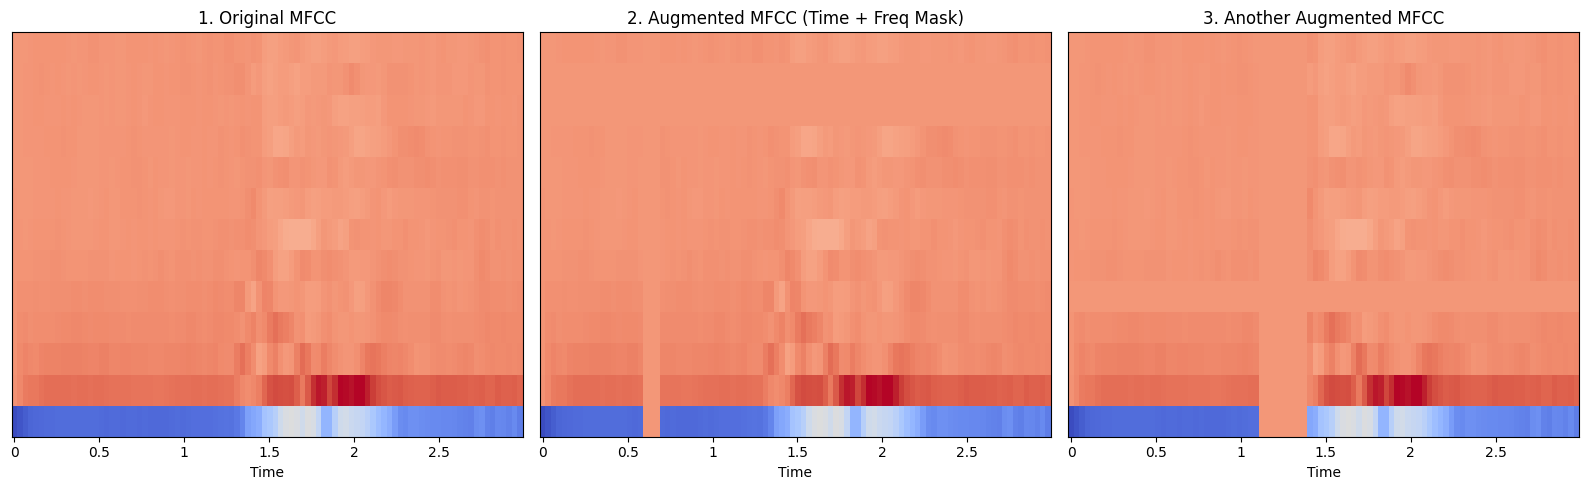

In [78]:
plt.figure(figsize=(16, 5))

# Original sample
plt.subplot(1, 3, 1)
librosa.display.specshow(X_combined[0].T, sr=TARGET_SR, x_axis='time')
plt.title("1. Original MFCC")

# Augmented 1
plt.subplot(1, 3, 2)
librosa.display.specshow(X_aug[len(X_combined)].T, sr=TARGET_SR, x_axis='time')
plt.title("2. Augmented MFCC (Time + Freq Mask)")

# Augmented 2
plt.subplot(1, 3, 3)
librosa.display.specshow(X_aug[len(X_combined) * 2].T, sr=TARGET_SR, x_axis='time')
plt.title("3. Another Augmented MFCC")

plt.tight_layout()
plt.show()

This cell splits the augmented data into training and validation sets. It ensures stratified splitting for balanced classes.

In [79]:
X_train, X_val, y_spk_train, y_spk_val, y_phr_train, y_phr_val = train_test_split(
    X_aug, y_speaker_aug, y_phrase_aug,
    test_size=0.2, random_state=42, stratify=y_speaker_aug
)

print(f"Training samples: {X_train.shape[0]} | Validation samples: {X_val.shape[0]}")

Training samples: 124 | Validation samples: 32


This cell builds the multi-output CNN model for speaker (5 classes) and phrase (2 classes). It uses convolutional layers for feature extraction, with dropout for regularization.

In [80]:
inputs = layers.Input(shape=(94, 13, 1))

x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)

speaker_out = layers.Dense(5, activation='softmax', name='speaker')(x)  # 5 classes (known + unknown)
phrase_out = layers.Dense(2, activation='softmax', name='phrase')(x)

model = models.Model(inputs, [speaker_out, phrase_out])

model.compile(
    optimizer='adam',
    loss={'speaker': 'sparse_categorical_crossentropy', 'phrase': 'sparse_categorical_crossentropy'},
    loss_weights={'speaker': 1.0, 'phrase': 0.5},
    metrics={'speaker': 'accuracy', 'phrase': 'accuracy'}
)

print("Model built and compiled.")
model.summary()

Model built and compiled.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 94, 13, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 94, 13,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 13,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 47, 6, 32) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 47, 6, 64) │     18,496 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 6, 64) │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 23, 3, 64) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 23, 3,     │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 3,     │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ speaker (Dense)     │ (None, 5)         │        645 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ phrase (Dense)      │ (None, 2)         │        258 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,983 (433.53 KB)

 Trainable params: 110,535 (431.78 KB)

 Non-trainable params: 448 (1.75 KB)

This cell trains the model on the split data. It uses early stopping and learning rate reduction for optimal training.

In [81]:
history = model.fit(
    X_train[..., np.newaxis],
    [y_spk_train, y_phr_train],
    validation_data=(X_val[..., np.newaxis], [y_spk_val, y_phr_val]),
    epochs=40,
    batch_size=8,
    verbose=1,
    callbacks=[
        callbacks.EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss'),
        callbacks.ReduceLROnPlateau(patience=4, monitor='val_loss')
    ]
)

print("\nTraining complete!")

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 766ms/step - loss: 1.8221 - phrase_accuracy: 0.5548 - phrase_loss: 0.7268 - speaker_accuracy: 0.4480 - speaker_loss: 1.4581 - val_loss: 2.1641 - val_phrase_accuracy: 0.4375 - val_phrase_loss: 0.8632 - val_speaker_accuracy: 0.3750 - val_speaker_loss: 1.7325 - learning_rate: 0.0010
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.2577 - phrase_accuracy: 0.7185 - phrase_loss: 0.5792 - speaker_accuracy: 0.6738 - speaker_loss: 0.9688 - val_loss: 1.6079 - val_phrase_accuracy: 0.5312 - val_phrase_loss: 0.6579 - val_speaker_accuracy: 0.6562 - val_speaker_loss: 1.2790 - learning_rate: 0.0010
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0604 - phrase_accuracy: 0.6051 - phrase_loss: 0.6471 - speaker_accuracy: 0.8258 - speaker_loss: 0.7359 - val_loss: 1.8574 - val_phrase_accuracy: 0.6250 - val_phrase_loss: 0.6184 - val_speaker_accuracy: 0.3438 - val_speaker_loss: 1.5482 - learning_rate: 0.0010
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━

This cell plots training and validation accuracy/loss. It helps monitor overfitting or underfitting.

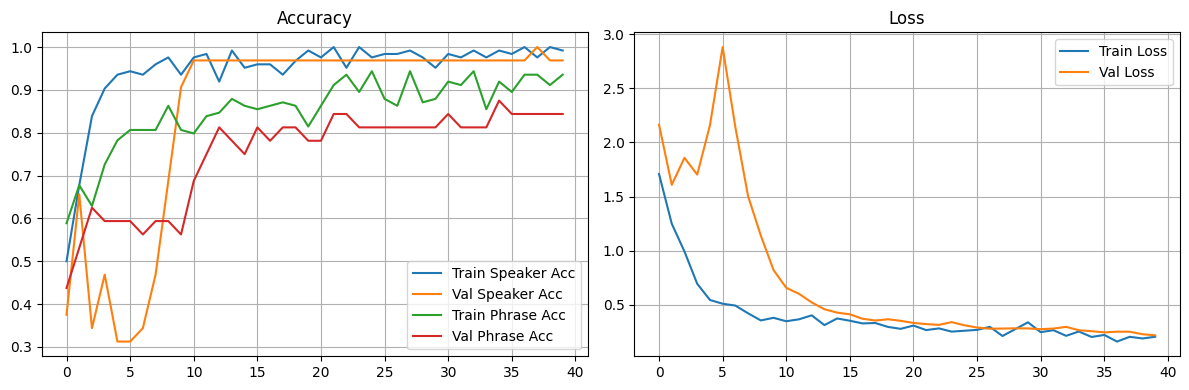

In [82]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['speaker_accuracy'], label='Train Speaker Acc')
plt.plot(history.history['val_speaker_accuracy'], label='Val Speaker Acc')
plt.plot(history.history['phrase_accuracy'], label='Train Phrase Acc')
plt.plot(history.history['val_phrase_accuracy'], label='Val Phrase Acc')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

This cell evaluates the model on validation data with classification reports and confusion matrices. It provides accuracy, precision, recall, F1, and visual confusion.

SPEAKER CLASSIFICATION REPORT
              precision    recall  f1-score   support

       james     1.0000    1.0000    1.0000        11
     mathias     1.0000    1.0000    1.0000         4
      pretty     1.0000    1.0000    1.0000         4
     souvede     1.0000    0.7500    0.8571         4
     unknown     0.9000    1.0000    0.9474         9

    accuracy                         0.9688        32
   macro avg     0.9800    0.9500    0.9609        32
weighted avg     0.9719    0.9688    0.9673        32


PHRASE CLASSIFICATION REPORT
                     precision    recall  f1-score   support

confirm transaction     0.8000    0.8571    0.8276        14
        yes approve     0.8824    0.8333    0.8571        18

           accuracy                         0.8438        32
          macro avg     0.8412    0.8452    0.8424        32
       weighted avg     0.8463    0.8438    0.8442        32


Overall Speaker Accuracy: 0.9688
Overall Phrase Accuracy: 0.8438


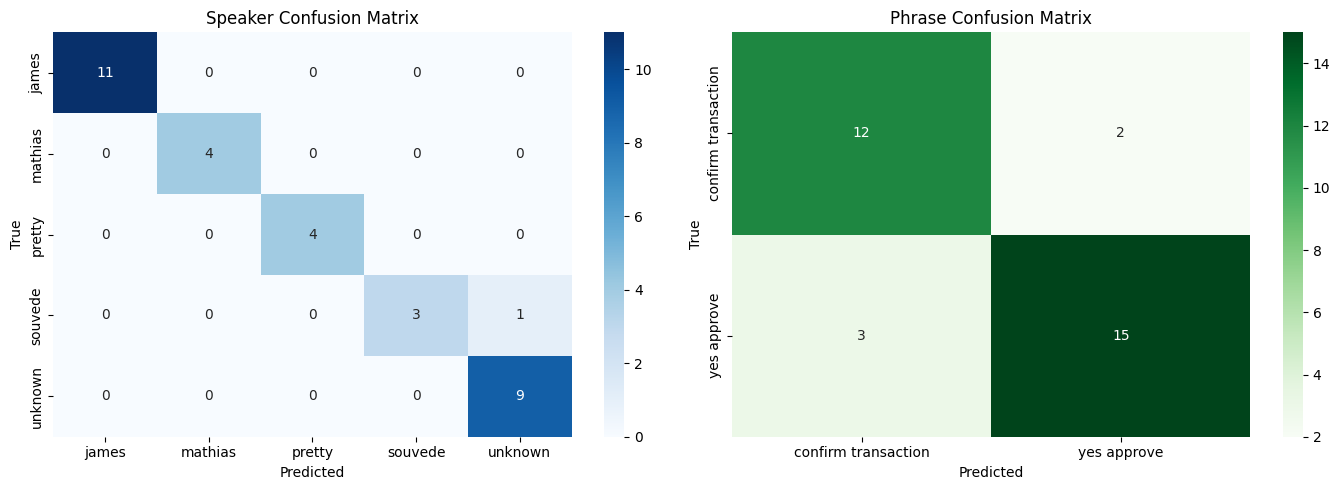

In [83]:
X_val_exp = X_val[..., np.newaxis]
pred_speaker, pred_phrase = model.predict(X_val_exp, verbose=0)
pred_speaker_labels = np.argmax(pred_speaker, axis=1)
pred_phrase_labels = np.argmax(pred_phrase, axis=1)

# Speaker Report
print("="*50)
print("SPEAKER CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_spk_val, pred_speaker_labels, target_names=speaker_encoder_5.classes_, digits=4))

# Phrase Report
print("\n" + "="*50)
print("PHRASE CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_phr_val, pred_phrase_labels, target_names=phrase_encoder.classes_, digits=4))

speaker_acc = accuracy_score(y_spk_val, pred_speaker_labels)
phrase_acc = accuracy_score(y_phr_val, pred_phrase_labels)
print(f"\nOverall Speaker Accuracy: {speaker_acc:.4f}")
print(f"Overall Phrase Accuracy: {phrase_acc:.4f}")

# Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

cm_speaker = confusion_matrix(y_spk_val, pred_speaker_labels)
sns.heatmap(cm_speaker, annot=True, fmt='d', cmap='Blues', xticklabels=speaker_encoder_5.classes_, yticklabels=speaker_encoder_5.classes_, ax=ax1)
ax1.set_title('Speaker Confusion Matrix')
ax1.set_ylabel('True')
ax1.set_xlabel('Predicted')

cm_phrase = confusion_matrix(y_phr_val, pred_phrase_labels)
sns.heatmap(cm_phrase, annot=True, fmt='d', cmap='Greens', xticklabels=phrase_encoder.classes_, yticklabels=phrase_encoder.classes_, ax=ax2)
ax2.set_title('Phrase Confusion Matrix')
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')

plt.tight_layout()
plt.show()

This cell saves the trained model and label encoders to Drive. It ensures the system can be loaded for inference later.

In [84]:
model.save('/content/drive/MyDrive/Formative 2 - Images and Audios/voice_auth/voice_auth_model_5class.h5')

with open('/content/drive/MyDrive/Formative 2 - Images and Audios/voice_auth/speaker_encoder_5.pkl', 'wb') as f:
    pickle.dump(speaker_encoder_5, f)

with open('/content/drive/MyDrive/Formative 2 - Images and Audios/voice_auth/phrase_encoder.pkl', 'wb') as f:
    pickle.dump(phrase_encoder, f)

print("Model and encoders saved successfully!")

Model and encoders saved successfully!


This cell loads the saved model and encoders for inference. It defines helper functions for preprocessing and prediction.

In [85]:
model = load_model('/content/drive/MyDrive/Formative 2 - Images and Audios/voice_auth/voice_auth_model_5class.h5')

with open('/content/drive/MyDrive/Formative 2 - Images and Audios/voice_auth/speaker_encoder_5.pkl', 'rb') as f:
    speaker_encoder_5 = pickle.load(f)

with open('/content/drive/MyDrive/Formative 2 - Images and Audios/voice_auth/phrase_encoder.pkl', 'rb') as f:
    phrase_encoder = pickle.load(f)

def preprocess_audio(file_path):
    # Preprocess audio file to MFCC features for inference.
    y, sr = librosa.load(file_path, sr=TARGET_SR)
    if len(y) > MAX_SAMPLES:
        y = y[:MAX_SAMPLES]
    else:
        y = np.pad(y, (0, MAX_SAMPLES - len(y)), mode='constant')
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T
    return mfcc[np.newaxis, ..., np.newaxis]  # Add batch/channel dims

def predict_voice(audio_path, phr_thresh=0.8):
    # Predict speaker and phrase from audio file.
    # Returns speaker name if known and phrase valid; else rejects.
    try:
        X = preprocess_audio(audio_path)
        spk_pred, phr_pred = model.predict(X, verbose=0)
        spk_idx = np.argmax(spk_pred)
        phr_conf = np.max(phr_pred)
        speaker = speaker_encoder_5.classes_[spk_idx]
        if speaker == 'unknown':
            return "unknown user"
        elif phr_conf < phr_thresh:
            return "invalid phrase"
        else:
            return speaker
    except Exception as e:
        return f"Error: {e}"

This cell tests the model on known and unknown audio files. It demonstrates inference in action.

In [86]:
# Test known audio
known_file = "/content/drive/MyDrive/Formative 2 - Images and Audios/voice_auth/pretty/pretty_approve_1.m4a"
print(f"Known audio result: {predict_voice(known_file)}")

# Test unknown audio
unknown_file = "/content/drive/MyDrive/Formative 2 - Images and Audios/voice_auth/unknown/stranger_approve_1.m4a"
print(f"Unknown audio result: {predict_voice(unknown_file)}")

# Optional: Test new unseen voice (record and upload)
new_stranger_file = "/content/drive/MyDrive/Formative 2 - Images and Audios/voice_auth/unknown/find.mp3"  # Update path
print(f"New stranger result: {predict_voice(new_stranger_file)}")

Known audio result: pretty
Unknown audio result: unknown user
New stranger result: unknown user
